--- 
Project for the course in Microeconometrics | Summer 2021, M.Sc. Economics, Bonn University | [Philipp Schreiber](https://github.com/pcschreiber1)

# Replication of Henderson, Storeygard, Deichmann (2017) :
## Has climate change driven urbanization in Africa? <a class="tocSkip">   
    
    
---

##### Downloading and viewing this notebook:

* The original paper, as well as the data and code provided by the authors can be accessed [here](https://doi.org/10.1016/j.jdeveco.2016.09.001).

## Content:
Extension: 
 - Spatial SUTVA/
 - Spatially explicit counterfactual framework
     - using exploration of SUTVA and spatial patters
     - implementing (lagged dependent, lagged 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.options.display.float_format = "{:,.2f}".format

In [2]:
from auxiliary.data_import import *

# First I need to prepare the data - later i will transform it into a function and put it into the auxiliary file

In [3]:
%whos

Variable               Type        Data/Info
--------------------------------------------
figure_4               function    <function figure_4 at 0x0000021E8C164310>
importing_regiondata   function    <function importing_regio<...>ta at 0x0000021E8C164160>
np                     module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
pd                     module      <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt                    module      <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
smf                    module      <module 'statsmodels.form<...>models\\formula\\api.py'>
table_1_a              function    <function table_1_a at 0x0000021E8C1641F0>
table_2                function    <function table_2 at 0x0000021E8C164280>
table_6                function    <function table_6 at 0x0000021E8C1643A0>


In [4]:
regiondata = importing_regiondata()
#regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")

a = table_1_a(regiondata)
regiondata[["ADurbfrac", "ADsm0_1moistu", "ADsm0_2moistu", "extent_agE_ADsm0_2moistu", "countryyear", "afruid"]].head()

,ADurbfrac,ADsm0_1moistu,ADsm0_2moistu,extent_agE_ADsm0_2moistu,countryyear,afruid
0,0.02,0.03,0.02,0.14,5.00,72001
1,0.03,0.01,-0.01,-0.06,5.00,72002
2,0.01,0.03,0.00,0.04,5.00,72004
3,0.03,0.03,0.01,0.07,5.00,72005
4,0.00,0.04,0.02,0.20,5.00,72006


In [5]:
table_2(regiondata).params[["ADsm0_2moistu", "firsturbfrac",  "lndiscst"]]

ADsm0_2moistu   -0.08
firsturbfrac    -0.05
lndiscst         0.00
dtype: float64

In [6]:
df_subgroup = regiondata[["isoyr", "iso3v10", "province"]]
df_subgroup.loc[(slice(20,30))]

,isoyr,iso3v10,province
20,CMR1987,CMR,Sud-Ouest
21,CMR2005,CMR,Sud-Ouest
22,CAF1988,CAF,Bamingui-Bangoran
23,CAF2003,CAF,Bamingui-Bangoran
24,CAF1988,CAF,Basse-Kotto
25,CAF2003,CAF,Basse-Kotto
26,CAF1988,CAF,Haut-Mbomou
27,CAF2003,CAF,Haut-Mbomou
28,CAF1988,CAF,Haute-Kotto
29,CAF2003,CAF,Haute-Kotto


## Exploring countrydata and reproducing Figure 4 (Variability in climate change in Africa)

In [7]:
countrydata_allyears = pd.read_stata("data/countrydata_allyears.dta")

countrydata_allyears["sm0_2normarid"] = countrydata_allyears["sm0_2moistu"]/ countrydata_allyears["mean_moistu1950_69"]

In [8]:
countrydata_allyears.head()

,year,iso3v10,moistu,sm0_2moistu,sm0_2preu,sm0_2tmpu,yearssince_prev_census,isonv10,areasqkm,urbpop,...,sum_agE,_merge,ADurbfrac,ADprimatefrac,ADprimwidefrac,ADsm0_2moistu,ADsm0_2preu,ADsm0_2tmpu,mean_moistu1950_69,sm0_2normarid
0,1950,BWA,0.42,NaN,NaN,NaN,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,NaN
1,1951,BWA,0.39,NaN,NaN,NaN,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,NaN
2,1952,BWA,0.36,0.39,427.86,21.61,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,0.99
3,1953,BWA,0.47,0.41,434.43,21.21,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,1.03
4,1954,BWA,0.46,0.43,454.84,21.13,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,1.09


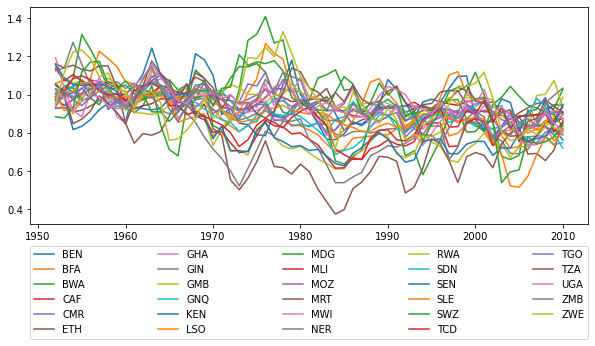

In [9]:
countrydata_allyears = pd.read_stata("data/countrydata_allyears.dta")
figure_4(countrydata_allyears)

### Exploring City data and reproducing table 6 (Change in city output and rainfall: heterogeneity by industrialization)

In [22]:
citydata = pd.read_stata("data/citydata.dta")
#citydata[["iso3v10", "year", "dlnrain30", "dlnl1", "agidison"]]
citydata.head()

,iso3v10,agidison,extent_agE,extent_agH,year,rain30,cityavgrain1983_1991,rain30trim257,cityavgrain1983_1991trim257,todn,...,extent_agHcflcnt3,extent_agHLcflcnt3,extent_agHcflcnt3_50,extent_agHLcflcnt3_50,extent_agH_dlnrainnatconflict,extent_agH_dlnrainLnatconflict,extent_agH_dlnraincflcnt3,extent_agH_dlnrainLcflcnt3,extent_agH_dlnraincflcnt3_50,extent_agH_dlnrainLcflcnt3_50
0,MRT,6082478,10.00,14.00,0.00,0.11,0.21,0.10,0.12,851.00,...,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MRT,6082478,10.00,14.00,1.00,0.17,0.21,0.14,0.12,"1,170.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,MRT,6082478,10.00,14.00,2.00,0.27,0.21,0.11,0.12,"1,073.50",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,MRT,6082478,10.00,14.00,3.00,0.21,0.21,0.11,0.12,"1,359.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,MRT,6082478,10.00,14.00,4.00,0.23,0.21,0.14,0.12,"1,457.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
